In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
import os, sys
sys.path.append('eval')
from forecast import *
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

In [19]:
graph_file = 'data/graphs/400950-400951_n5.json'

In [3]:
DENSE = True
EPS = 120
LAG = 24 + 1
SROUTE, _ = read_graph(graph_file, named_adj=True, verbose=False)
HSIZE = 128
STOPS = len(SROUTE)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
for seg in SROUTE:
    print(seg)

400950-400951
405297-404153
400861-403781
401348-400860
400948-404050
400953-405297
400860-400861
401358-401359
403797-405297
400861-400948
404153-401358
403797-400953
404138-400860
404050-400950
400951-403797


In [5]:
dset = SpotHistory(SROUTE, 'train', 32, lag=LAG, res=10).generator()
valset = SpotHistory(SROUTE, 'test', 32, lag=LAG, res=10).generator()

Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [400950-400951]: 90
    * [405297-404153]: 90
    * [400861-403781]: 90
    * [401348-400860]: 90
    * [400948-404050]: 90
    * [400953-405297]: 90
    * [400860-400861]: 90
    * [401358-401359]: 90
    * [403797-405297]: 90
    * [400861-400948]: 90
    * [404153-401358]: 90
    * [403797-400953]: 90
    * [404138-400860]: 90
    * [404050-400950]: 90
    * [400951-403797]: 90
 [*] Examples (train): 6559
 [*] Time range: 2014-08-01 ~ 2014-10-31
Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [400950-400951]: 90
    * [405297-404153]: 90
    * [400861-403781]: 90
    * [401348-400860]: 90
    * [400948-404050]: 90
    * [400953-405297]: 90
    * [400860-400861]: 90
    * [401358-401359]: 90
    * [403797-405297]: 90
    * [400861-400948]: 90
    * [404153-401358]: 90
    * [403797-400953]: 90
    * [404138-400860]: 90
    * [404050-400950]: 90
    * [400951-403797]: 90
 [*] Examples (test): 1715
 [*] Time range: 2014-08-01 ~ 2014-10-

In [6]:
from models.temporal.RNN import *
# lag = 6th timestep is predicted based on past 5 (50 mins
if not DENSE:
    model = RNN_MIN(hidden_size=HSIZE, steps=STOPS).to(device)
else:
    model = RNN(hidden_size=HSIZE, steps=STOPS).to(device)
model.device = device

In [7]:
criterion, opt, sch = model.params(lr=0.001)

In [8]:
# batch x timesteps x location
evf = lambda: evaluate(
    valset, model, crit=lambda _y, y: criterion(_y[:, :, 0], y[:, :, 0]).item())
_ = evf()

Eval loss: 197.4609          


In [9]:
losses = []
eval_mse = []
eval_mape = []

In [10]:
from numpy.random import randint
for eii  in range(EPS):
    bls = []
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        bls.append(loss.item())
        sys.stdout.write('[%d/%d : %d/%d] - L%.2f %s      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item(),
            '(avg %.2f)' % (10 ** 2 * np.mean(bls)) if bii == len(dset) -1 else ''
        ))
        

    sys.stdout.write('\n')
    eval_mse.append(evf())
    sys.stdout.flush()
    sch.step()

[1/120 : 205/205] - L4.57 (avg 11.90)      
Eval loss: 6.8788           
[2/120 : 205/205] - L1.14 (avg 2.78)      
Eval loss: 1.3817          
[3/120 : 205/205] - L0.60 (avg 0.89)      
Eval loss: 0.6101          
[4/120 : 205/205] - L0.30 (avg 0.37)      
Eval loss: 0.3756          
[5/120 : 205/205] - L0.20 (avg 0.27)      
Eval loss: 0.3137          
[6/120 : 205/205] - L0.20 (avg 0.22)      
Eval loss: 0.2785          
[7/120 : 205/205] - L0.20 (avg 0.19)      
Eval loss: 0.2429          
[8/120 : 205/205] - L0.16 (avg 0.16)      
Eval loss: 0.2380          
[9/120 : 205/205] - L0.15 (avg 0.14)      
Eval loss: 0.2096          
[10/120 : 205/205] - L0.12 (avg 0.13)      
Eval loss: 0.1813          
[11/120 : 205/205] - L0.12 (avg 0.12)      
Eval loss: 0.2452          
[12/120 : 205/205] - L0.14 (avg 0.11)      
Eval loss: 0.1597          
[13/120 : 205/205] - L0.08 (avg 0.10)      
Eval loss: 0.1580          
[14/120 : 205/205] - L0.09 (avg 0.09)      
Eval loss: 0.1342          

Eval loss: 0.1392          
[115/120 : 205/205] - L0.05 (avg 0.04)      
Eval loss: 0.1486          
[116/120 : 205/205] - L0.03 (avg 0.05)      
Eval loss: 0.1479          
[117/120 : 205/205] - L0.04 (avg 0.04)      
Eval loss: 0.1443          
[118/120 : 205/205] - L0.04 (avg 0.04)      
Eval loss: 0.1586          
[119/120 : 205/205] - L0.04 (avg 0.04)      
Eval loss: 0.1371          
[120/120 : 205/205] - L0.05 (avg 0.04)      
Eval loss: 0.1489          


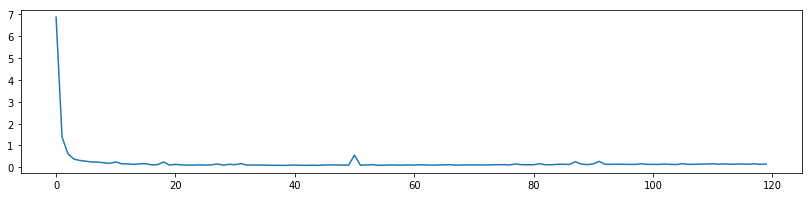

In [11]:
plt.figure(figsize=(14, 3))
plt.plot(eval_mse)
plt.show(); plt.close()

In [13]:
testset = SpotHistory(SROUTE, 'test', 18, lag=None, res=10, shuffle=False, verbose=True)

Full history
 [*] Segments: 90 co-avail
    * [400950-400951]: 90
    * [405297-404153]: 90
    * [400861-403781]: 90
    * [401348-400860]: 90
    * [400948-404050]: 90
    * [400953-405297]: 90
    * [400860-400861]: 90
    * [401358-401359]: 90
    * [403797-405297]: 90
    * [400861-400948]: 90
    * [404153-401358]: 90
    * [403797-400953]: 90
    * [404138-400860]: 90
    * [404050-400950]: 90
    * [400951-403797]: 90
 [*] Examples (test): 18
 [*] Time range: 2014-08-01 ~ 2014-10-31


In [14]:
sqerr = eval_rnn(testset, model, plot=False)
print('Eval segments:', len(viewset))
print('Eval MSE: %.4f' % np.mean(sqerr))

Eval segments: 18
Eval MSE: 0.1365


Using fringes: 4


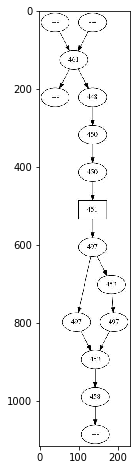

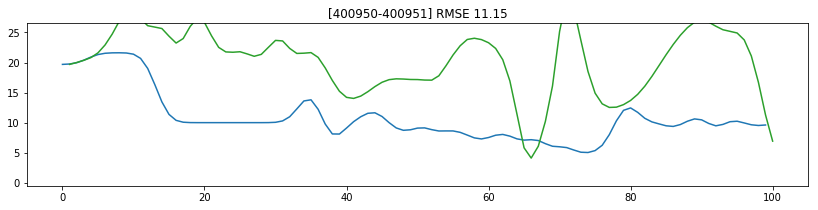

Using fringes: 4


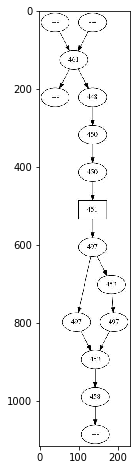

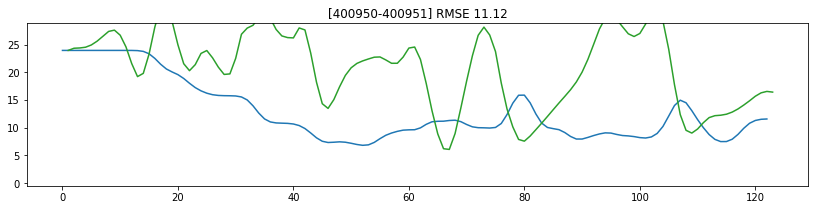

Using fringes: 4


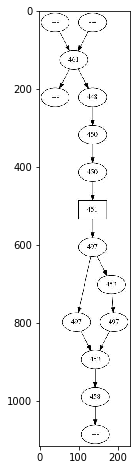

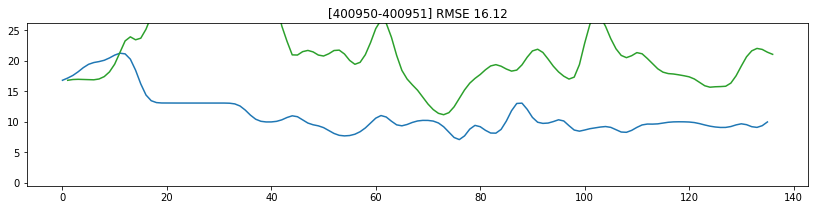

Using fringes: 4


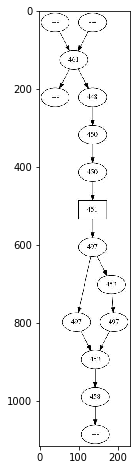

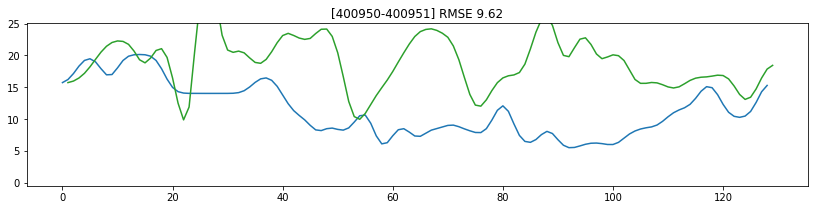

Using fringes: 4


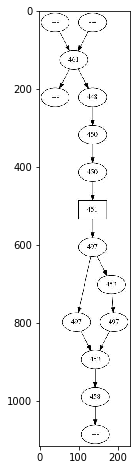

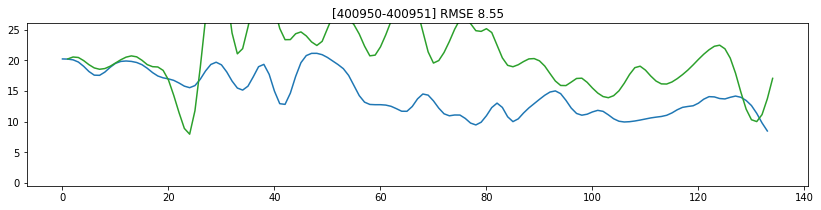

In [38]:
for ii in range(5):
    _ = forecast_rnn(testset[ii], model, graph_file, verbose=True, twoway=True)

In [17]:
sname = 'checkpoints/rnn_%s_h1.pth' % ('thin' if not DENSE else 'dense')
sname

'checkpoints/rnn_dense_h1.pth'

In [18]:
# torch.save(
#     model.state_dict(), 
#     sname)